# Basemap segmentation with Segment Anything Model (SAM) Workflow

This notebook demonstrates how to segment BingMaps basemaps, using a FarmVibes.AI workflow that leverages [Segment Anything Model](https://github.com/facebookresearch/segment-anything) (SAM). 

**Note:** if you are interested in an example that runs SAM outside of FarmVibes.AI cluster, refer to the `sam_exploration.ipynb` notebook.

The notebook is divided into the following sections:

1. **Environment setup**: this section provides instructions for obtaining a BingMaps API key, setting up the conda environment for FarmVibes.AI, and importing the necessary libraries for the notebook. We also download and export the ONNX files required to run SAM workflows to our cluster.

2. **Workflow setup**: we define a location and time range of interest for our analysis, and build our prompt with multiple points.

3. **Running the workflow**: this section discusses the parameters of the SAM workflow and demonstrates how to run it.

4. **Visualizing the results**: finally, we visualize the results of the workflow.

We run steps 3 and 4 for a few different parameter combinations to demonstrate the effect of the parameters on the results.


## Environment setup

### BingMaps API key
Before running FarmVibes.AI workflows that download BingMaps basemaps, make sure you have an API key for BingMaps. You can get one through the [BingMaps Developer Portal](https://www.bingmapsportal.com/).

Please, make sure you edit the `BINGMAPS_API_KEY` variable in the cell below with your API key:

In [1]:
BING_MAPS_API_KEY = ""

### Conda environment

Before running this notebook, make sure to set up a conda environment with all the required dependencies for FarmVibes.AI.

**If you are importing the ONNX files to your cluster for the first time**, make sure the following environment is configured:

```bash
$ conda env create -f env_cpu.yml
$ conda activate segment_anything_cpu
```

**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ conda activate farmvibes-ai
```


### Importing SAM's ONNX models to the cluster

Before running SAM workflows in FarmVibes.AI, we need to add the model to our cluster. We provide a script that downloads the original weights from the [official repository](https://github.com/facebookresearch/segment-anything) and separately converts the image encoder and prompt encoder + mask decoder to ONNX format. The script also adds the ONNX models to our cluster, allowing them to be used in workflows.

To run the script, execute the following command **in the repository root**:

```bash
$ python scripts/export_sam_models.py --models < model_types >
```

where `<model_types>` is a list of model types to be exported (`vit_b`, `vit_l`, `vit_h`). For example, to export all three ViT backbones, run:

```bash
$ python scripts/export_sam_models.py --models vit_b vit_l vit_h
```

In this notebook, we will export the `vit_b` model:

In [ ]:
! python ../../scripts/export_sam_models.py --models vit_b

### Imports

In [29]:
import os
import sys

from datetime import datetime
from shapely import geometry as shpg
import matplotlib.pyplot as plt


from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid

# Add shared notebook library to path
sys.path.append("../")
from shared_nb_lib.utils import create_geojson_file_from_point
from shared_nb_lib.raster import s2_to_img, read_raster
from notebook_lib.utils import plot_rasters_prompts_masks

### Storage Path

To feed the prompts to the workflow, we will create a GeoDataFrame and save it in the FarmVibes.AI cache directory. During setup, FarmVibes.AI stores the path to the cache directory in `~/.config/farmvibes-ai/storage` (or `{XDG_CONFIG_HOME}/farmvibes-ai/storage` if you had a `XDG_CONFIG_HOME` environment variable set).

Make sure the `storage_dir` variable below points to the same path as the one in the storage file.

In [3]:
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config"))
storage_config_path = os.path.join(config_dir, "farmvibes-ai", "storage")
try:
    with open(storage_config_path) as f:
        storage_dir = f.read().strip()
    print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")
except FileNotFoundError:
    print(f"Could not find FarmVibes.AI cache directory at '{storage_config_path}'! Please assign the correct value to `storage_dir`")

Cache directory set to '/home/rpadilha/.cache/farmvibes-ai' by reading '/home/rpadilha/.config/farmvibes-ai/storage'


## Workflow setup

FarmVibes.AI has a few workflows related to SAM. In this example, we will use the `farm_ai/segmentation/segment_basemap` workflow, which employs the `data_ingestion/bing/basemap_download_merge` workflow to download a basemap-style image from BingMaps, running the segmentation on top of them. In addition to the `ExternalReferenceList` inputs for the prompts, this workflow expects a `DataVibe` with the geometry and a time range of interest.

Before inspecting how the workflow is defined, let's instantiate our client:


In [4]:
client = get_default_vibe_client()

The definition of the `farm_ai/segmentation/segment_basemap` workflow can be inspected with:

In [ ]:
client.document_workflow("farm_ai/segmentation/segment_basemap")

The workflow has four parameters:

- `bingmaps_api_key`: the BingMaps API key required to download the basemaps. You can get one on the [Bing Maps Developer Portal](https://www.bingmapsportal.com/).
- `basemap_zoom_level`: the zoom level of the basemap to be downloaded. The default value is 14, which corresponds to a resolution of roughly 9 meters per pixel, which is similar to the resolution of Sentinel-2 imagery.
- `model_type`: defines the backbone architecture for SAM's image encoder, among `vit_b`, `vit_l`, and `vit_h`. The default value is `vit_b`.
- `spatial_overlap`: the input raster is split into chips of size 1024x1024 pixels. This parameter defines the spatial overlap between chips in the segmentation process. The default value is 0.5, meaning that the chips will overlap by 50%.

Let's define a location and time range to download data from. In this example, we select a small region around a defined latitude/longitude and a time range of a few days.

In [9]:
geom = shpg.Point(74.924041, 17.940487).buffer(.01, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

roi_time_range = DataVibe(id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[])

We will also define a prompt with multiple points. The prompt is defined as a GeoDataFrame with the following columns:
- `geometry`: the list of points and/or bounding boxes that define the prompts.
- `label`: the label of each point, either 1 (the entity of interest or `foreground`) or 0 (not part of the entity of interest, or `background`).
- `prompt_id`: the id of the prompt to which each point belongs. Each prompt is defined as a set of points with the same `prompt_id`. The resulting segmentation mask will have a number of channels equal to the number of unique `prompt_id` values.

In this initial example, we will define 3 prompts. The first prompt will consist on four points across a river, whereas the remaining two prompts will be single-point prompts on two crop fields. The `prompt_id` values will be 0, 1, and 2, respectively, to highlight these are three different entities to be segmented. For now, the `label` values will be 1 for all points as we will not have 'background' points. The Sentinel-2 image and the prompts can be seen in the [next section](#visualizing-the-results).

In [24]:
point_list = [
        # Let's add a few points over the river
        shpg.Point(74.924202, 17.942116), 
        shpg.Point(74.929492, 17.941011), 
        shpg.Point(74.926339, 17.941406),
        shpg.Point(74.920655, 17.943872),
        shpg.Point(74.930446, 17.941031),
    ]
prompt_ids = [0, 0, 0, 0, 0] # single prompt_id for now
labels = [1, 1, 1, 1, 1] # all foreground

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
        id=f"geo_{fid}", 
        time_range=time_range, 
        geometry=shpg.mapping(geom), 
        assets=[], 
        urls=[filepath]
    )

/anaconda/envs/dev-vibes/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Running the workflow

In [30]:
run = client.run(
    "farm_ai/segmentation/segment_basemap", 
    "Basemap segmentation", 
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY, 
        "basemap_zoom_level": 16, 
        "model_type": "vit_b",
        "spatial_overlap": 0.5
        }
    )
run.monitor()

## Visualizing the results

The output of the segmentation is a mask with the same size as the input RoI, with each channels corresponding to a prompt. The values of the mask are 0 (background) or 1 (foreground). We can visualize the mask by plotting the mask for each prompt, as well as the foreground (green) and background (red) points used as prompts.

In this case, we have a single channel mask, as we only have one prompt. The mask is a binary mask, with 0s for the background and 1s for the foreground.

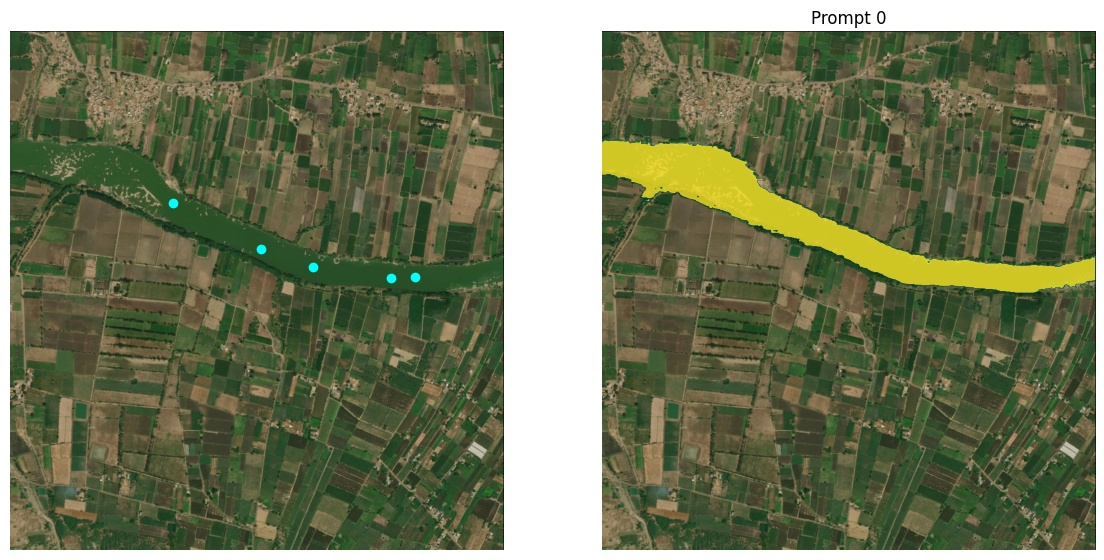

In [26]:
plot_rasters_prompts_masks(run.output["basemap"][0], run.output["segmentation_mask"][0], geom, gdf, labels)

For the segmentation above, we used a `basemap_zoom_level` of 16, which corresponds to a resolution of roughly 2.4 meters per pixel (almost 4 times higher than Sentinel-2 resolution). Even with this higher resolution, the crop fields are very small. The power of using BingMaps basemaps as input to the segmentation process is the possibility of leveraging higher resolution than Sentinel-2, which allows us to segment smaller entities. For comparison, below we show a side-by-side comparison of the Sentinel-2 image and the basemap used for the segmentation above.

In [31]:
sentinel_run = client.run(
    "data_ingestion/sentinel2/preprocess_s2", 
    "Sentinel-2 download", 
    input_data={"user_input": roi_time_range},
    )
sentinel_run.monitor()

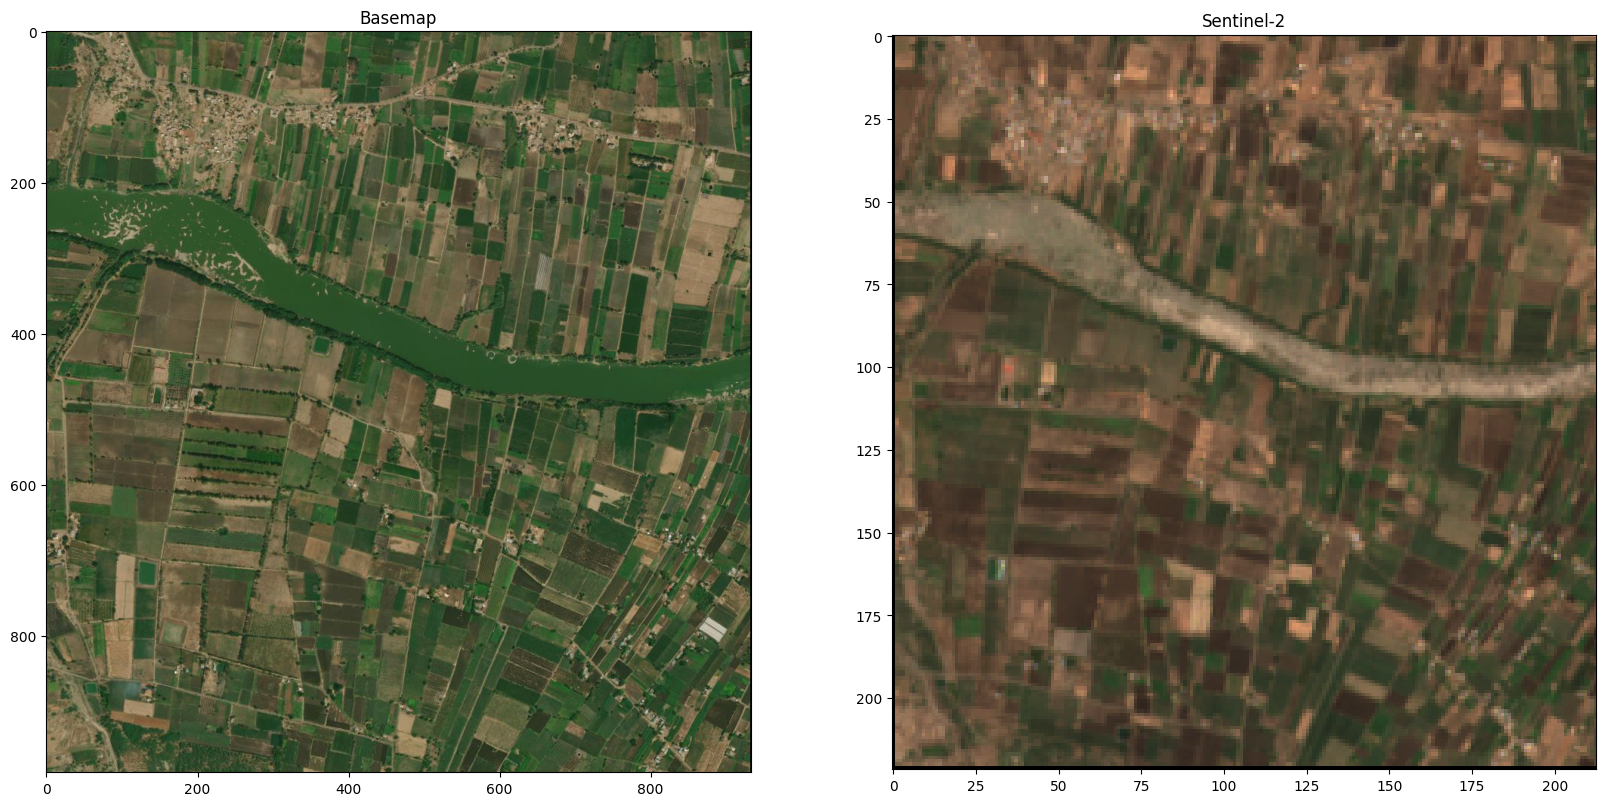

In [35]:
# Plot both basemap and sentinel-2 imagery side by side
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ar, _ = read_raster(run.output["basemap"][0], geometry=shpg.shape(roi_time_range.geometry))
basemap_img = ar.transpose(1, 2, 0)

ar, _ = read_raster(sentinel_run.output["raster"][0], geometry=shpg.shape(roi_time_range.geometry))
sentinel_img = s2_to_img(ar)

ax1.imshow(basemap_img)
ax1.set_title("Basemap")

ax2.imshow(sentinel_img)
ax2.set_title("Sentinel-2")

plt.show()

Not only does Sentinel-2 have a lower resolution than BingMaps basemaps, it may also be affected by cloud coverage, which would considerably hinder the quality of our segmentation. In this example, despite the lack of clouds in the Sentinel-2 image, we would still not be able to segment the crop fields in the image above due to the blurring and resolution. Let's try running the segmentation over a basemap focused a few fields in the center of the image, but using a higher zoom level.

In [62]:
geom = shpg.Point(74.924041, 17.940487).buffer(.002, cap_style=3)
roi_time_range = DataVibe(id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[])

point_list = [
        # Field 1
        shpg.Point(74.925263, 17.940571),
        # Field 2
        shpg.Point(74.924152, 17.941128),
        shpg.Point(74.923965, 17.940562),
        shpg.Point(74.923877, 17.939968),
        shpg.Point(74.924450, 17.940484), # negative point (background)
        # Field 3
        shpg.Point(74.923296, 17.940970),
    ]
prompt_ids = [0, 1, 1, 1, 1, 2] # same prompt id
labels = [1, 1, 1, 1, 0, 1] # foreground and background labels

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
        id=f"geo_{fid}", 
        time_range=time_range, 
        geometry=shpg.mapping(geom), 
        assets=[], 
        urls=[filepath]
    )

/anaconda/envs/dev-vibes/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


With those defined, we can now run the workflow once again:

In [63]:
run = client.run(
    "farm_ai/segmentation/segment_basemap", 
    "Basemap segmentation", 
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY, 
        "basemap_zoom_level": 19, 
        "model_type": "vit_b",
        "spatial_overlap": 0.5
        }
    )
run.monitor()

And visualize the results:

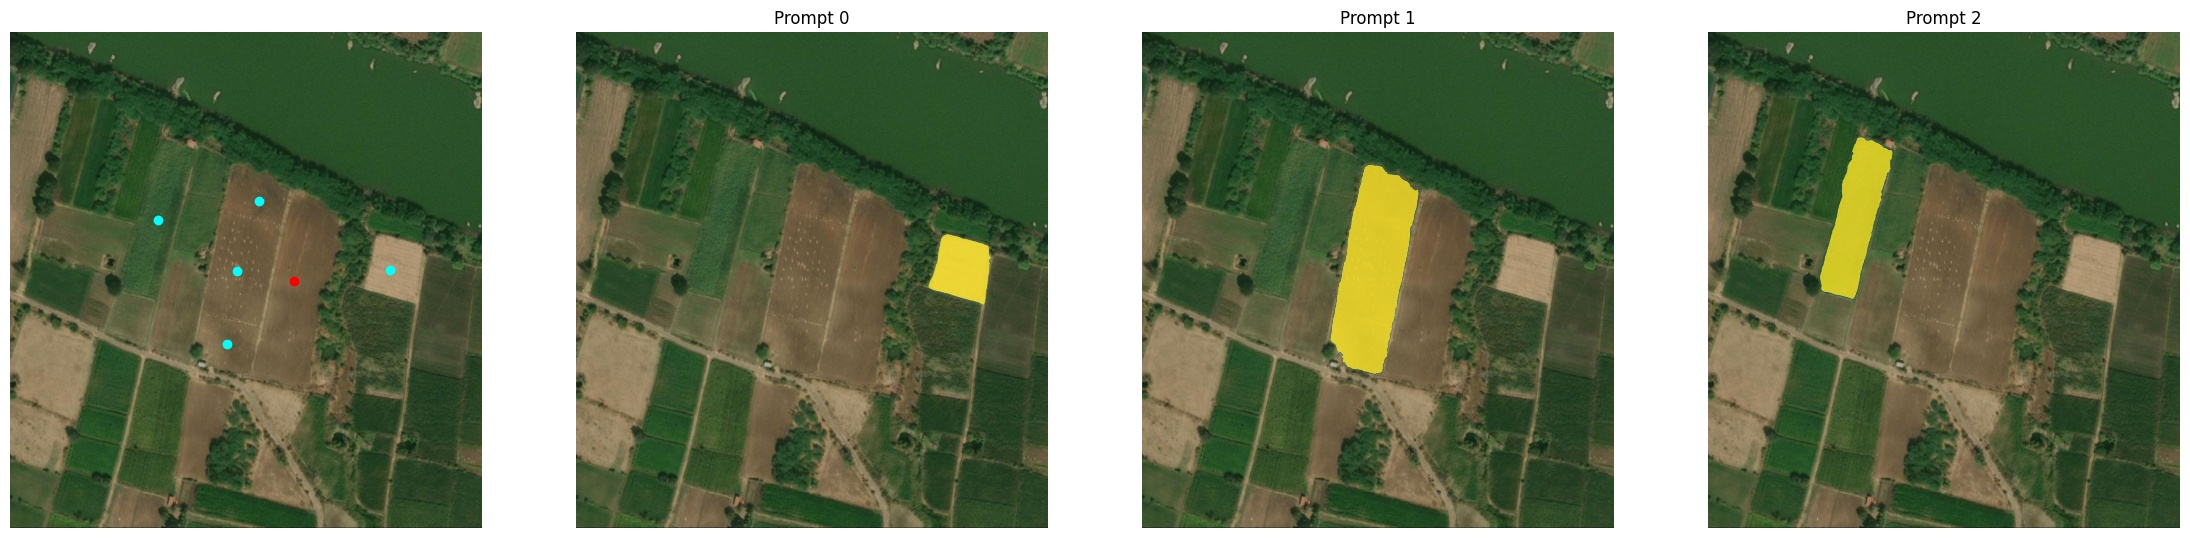

In [64]:
plot_rasters_prompts_masks(run.output["basemap"][0], run.output["segmentation_mask"][0], geom, gdf, labels)

## Bounding Boxes as prompts

We can also combine a set of points with a bounding box to limit the segmentation to a specific region. When using bounding boxes, the following aspects should be considered:

- Only a single bounding box is supported per prompt group (i.e., all points with the same `prompt_id`).
- We recommend providing at least one foreground point within the bounding box. Even though the model supports segmentating rasters with only a bounding box, the results may be unreliable in some cases. 
- If the prompt contains a foreground point outside the provided bounding box, the workflow will adjust the bounding box to include all foreground points in that prompt group.
- Background points outside the bounding box are ignored.
- Regions outside the bounding box will be masked out in the final segmentation mask.

We define a bounding box as a `shapely.geometry.Polygon`. In this example, we will use the `shapely.geometry.box` function to create a bounding box around one of the central fields:

In [72]:
point_list = [
        # Bounding box
        shpg.box(74.923667, 17.941709, 74.924501, 17.939555),
    ]
prompt_ids = [0]
labels = [1]

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", 
    time_range=time_range, 
    geometry=shpg.mapping(geom), 
    assets=[], 
    urls=[filepath]
)

# Running the workflow
run = client.run(
    "farm_ai/segmentation/segment_basemap", 
    "Basemap segmentation", 
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY, 
        "basemap_zoom_level": 19, 
        "model_type": "vit_b",
        "spatial_overlap": 0.5
        }
    )
run.monitor()

Let's visualize the results:

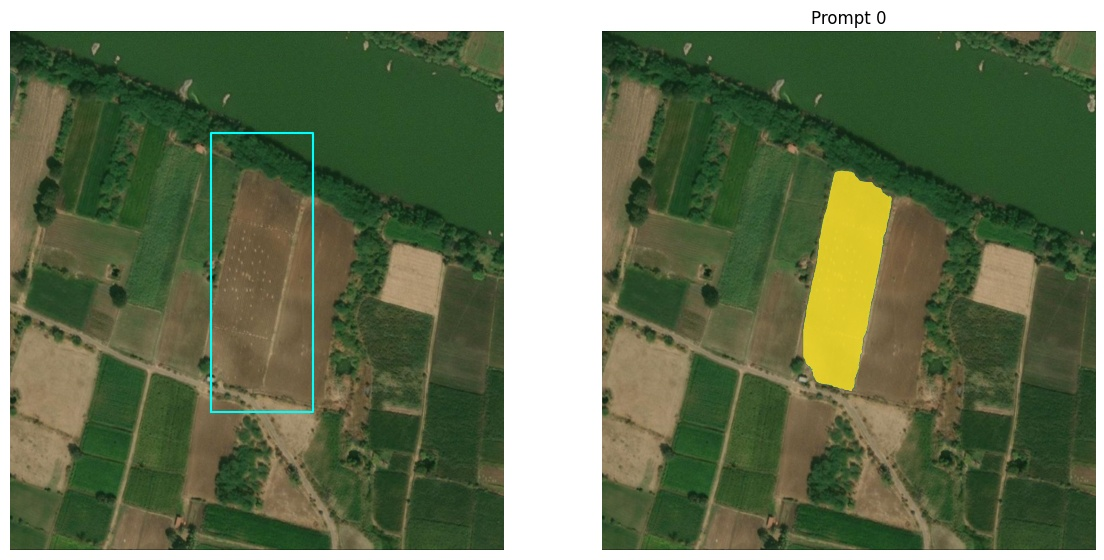

In [73]:
plot_rasters_prompts_masks(run.output["basemap"][0], run.output["segmentation_mask"][0], geom, gdf, labels)